# Clipboard Health Pricing WBD 
_Jupyter notebook containing analysis for the Clipboard Health Pricing WBD exercise. Prepared by Nick Turner._

### About
In order to be successful in a competitive marketplace, it's important for any company to have both a qualitative and quantitative understanding of their users and customers. Technology companies have the advantage of collecting massive amounts of data in almost real time. This comes at a cost, as turning data into usable signals has many challenges.  

This document is an attempt to make some sense of the dataset provided for a pricing exercise. The goal is to understand more about the current pricing model and look for areas of opportunity to inform a new pricing model. It goes as far as exploratory data analysis and does not attempt to build statistical models that can be used to predict optimal pricing. That will be left as an exercise for data science and engineering.

This level of rigor was not required to complete the working backwards documents. However, I had a few urgent issues pop up that kept interrupting my adhoc attempts at exploratory data analysis. Rather than restarting my informal analysis yet again, most of which relies on me having specific contexts loaded into my working memory, I decided to bite the bullet and use a tool I haven't used in a while: a jupyter notebook. While there was a bit of a learning (and relearning) curve, it has the advantage of being able to easily mix notes in markdown with reproducible analysis in python. 

##### Versions of this document:
- [github pages html version](https://bootstrapt.github.io/clipboard-health-wbd-notebook/) (code output visible, blocks not visible)  
- [github notebook page](https://github.com/bootstrapt/clipboard-health-wbd-notebook/blob/main/pricing_wbd.ipynb) (code output and blocks visible)  
- [github project](https://github.com/bootstrapt/clipboard-health-wbd-notebook) (source code)

### Table of Contents

1. [Initialization](#1.-Initialization) _setting up dependencies and configurations_
2. [Load Raw Shift Data](#2.-Load-Raw-Shift-Data): _loading and verifying the source data_
    1. [Load Data](#2A.-Load-Data)
    2. [Verify Data](#2B.-Verify-Data)
3. [Transform Data](#3.-Transform-Data): _copying, transforming, and extending the raw data_
4. [Explore Data](#4.-Explore-Data): _making sense of the data_
    1. [Are charge rates fixed per HCP?](#4A.-Are-charge-rates-fixed-per-HCP?)
    2. [What correlates with the variance in charge rates?](#4B.-What-correlates-with-the-variance-in-charge-rates?)
    3. [What correlates with Shift Status?](#4C.-What-correlates-with-Shift-Status?)
5. [Summary of Findings](#5.-Summary-of-Findings): _what we learned from the data_
    1. [Learnings](#5A.-Learnings)
    2. [Limitations](#5B.-Limitations)
    3. [Recommendations](#5C.-Recommendations)

## 1. Initialization
_Setting up dependencies and configurations. Please install the dependencies as noted on the [github page](https://github.com/bootstrapt/clipboard-health-wbd-notebook)._

#### Import Dependencies
Run this block to import the required packages and modules into the notebook environment, and setup helper functions.

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

# wrapper to display all rows of a dataframe
def displayall(df):
    old_max_rows = pd.options.display.max_rows
    pd.options.display.max_rows = None
    display(df)
    pd.options.display.max_rows = old_max_rows
    return True

print('✅ Successfully imported dependencies')

✅ Successfully imported dependencies


#### Configuration
Run this block to configure the notebook environment and its dependencies.

In [16]:
filterwarnings('ignore')
print('✅ Suppressing certain warnings when loading data (issue with openpxl, see references [1] below)')
 
%matplotlib inline
print('✅ Showing matplotlib plots inline')

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print('✅ Showing full dataframe tables')

pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print('✅ Set all decimal places to two')

# enable ipywidgets
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

✅ Suppressing certain warnings when loading data (issue with openpxl, see references [1] below)
✅ Showing matplotlib plots inline
✅ Showing full dataframe tables
✅ Set all decimal places to two
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## 2. Load Raw Shift Data
([back to top](#Table-of-Contents))  

Load the raw data from a downloaded excel spreadsheet and run a quick smoke test to verify the loaded data matches expected.

### 2A. Load Data
([back to top](#Table-of-Contents))   

_Import the Raw Shift Data sheet from the xlsx file._

In [18]:
path = ('./shifts dataset with unfilled for candidates.xlsx')
xl = pd.ExcelFile(path)
raw_shift_data = xl.parse('Raw Shift Data')
raw_shift_data.sample(3)

,agent_type,charge_rate_hourly,Created At,Created At (Month),hcf_id,hcp_id,Shift Start,Shift Start (Month),Lead Time (days),Shift End,Shift ID,Shift Status,Shift Time
6754,CNA,31.00,2020-09-16 22:09:00,2020-09-16,5eebe1ec00957c0017a41c49,5e8b8f15fef72700164816c5,2020-09-23 06:09:00,2020-09-23,7,2020-09-23 21:30:00,5f628befa204690016c9e8e5,verified,noc
6647,CNA,31.00,2020-09-08 22:09:00,2020-09-08,5cb9f07135163900163f532c,NaN,2020-09-20 06:09:00,2020-09-20,12,2020-09-20 21:30:00,5f580b715684fc001618d0e3,Unfilled,noc
6084,CNA,35.00,2020-09-03 20:09:00,2020-09-03,5db36e75128eb90016d0b8a1,NaN,2020-09-05 13:09:00,2020-09-05,2,2020-09-06 05:00:00,5f514d7caeb9cb0016ef7f24,Unfilled,am


### 2B. Verify Data
([back to top](#Table-of-Contents))  

_Run the block below to verify that the data has the same columns and number of rows as the dataset we are expecting. Change the `expected_raw_shift_data_types` keys or value types to demo error handling._

In [4]:
expected_raw_shift_data_types = pd.core.series.Series({
    'agent_type': np.dtype('O'),
    'charge_rate_hourly': np.dtype('float64'),
    'Created At': np.dtype('<M8[ns]'),
    'Created At (Month)': np.dtype('<M8[ns]'),
    'hcf_id': np.dtype('O'),
    'hcp_id': np.dtype('O'),
    'Shift Start': np.dtype('<M8[ns]'),
    'Shift Start (Month)': np.dtype('<M8[ns]'),
    'Lead Time (days)': np.dtype('int64'),
    'Shift End': np.dtype('<M8[ns]'),
    'Shift ID': np.dtype('O'),
    'Shift Status': np.dtype('O'),
    'Shift Time': np.dtype('O')
})
expected_raw_shift_data_shape = (8404, 13)

actual_column_names = raw_shift_data.columns.to_list()
expected_column_names = list(expected_raw_shift_data_types.keys())

def compareLists(expected, actual):
    missing = []
    extra = []
    for n in expected:
        if n not in actual:
            missing.append(n)
    for n in actual:
        if n not in expected:
            extra.append(n)
    return {'missing': missing, 'extraneous': extra}

print('Does the data shape match expected?')
print(expected_raw_shift_data_shape == raw_shift_data.shape)
print()
print('Do column types match expected?')

try:
    # prints all column names and whether the dataframe types match expected
    combined_raw_shift_data_types = pd.concat([
            expected_raw_shift_data_types.to_frame(name='type'), 
            (expected_raw_shift_data_types == raw_shift_data.dtypes).to_frame(name='match')
        ],
        axis=1, 
        names=['column']
    )
    print(combined_raw_shift_data_types)
    
except ValueError as e:
    # handle error where column names do not match, guiding user
    if str(e) == 'Can only compare identically-labeled Series objects':
        headers_diff = compareLists(expected_column_names, actual_column_names)
        print('Error. Column names do not match expected, could not check column types.\n')
        print('Extraneous Columns (remove): {}'.format(headers_diff['extraneous']))
        print('      Missing Columns (add): {}'.format(headers_diff['missing']))
    else:
        print('Other ValueError: {}'.format(e))

Does the data shape match expected?
True

Do column types match expected?
                               type  match
agent_type                   object   True
charge_rate_hourly          float64   True
Created At           datetime64[ns]   True
Created At (Month)   datetime64[ns]   True
hcf_id                       object   True
hcp_id                       object   True
Shift Start          datetime64[ns]   True
Shift Start (Month)  datetime64[ns]   True
Lead Time (days)              int64   True
Shift End            datetime64[ns]   True
Shift ID                     object   True
Shift Status                 object   True
Shift Time                   object   True


## 3. Transform Data
([back to top](#Table-of-Contents))  

_Cleaning and extending the data for further processing. To see a list of the changes, please see the comments in the code block._ 

In [5]:
# delete existing dataframe if it exists
try:
    del tr_shift_data
except NameError:
    pass

# create transformed shift data dataframe
tr_shift_data = raw_shift_data.copy()

# add column `Shift Start DoW` with the day of the week the shift is on (e.g. "Monday")
tr_shift_data['Shift Start DoW'] = tr_shift_data['Shift Start'].dt.day_name()

# add column `Shift Length` with the length of the shift
tr_shift_data['Shift Length'] = tr_shift_data['Shift End'] - tr_shift_data['Shift Start']

# replace NaN values with empty strings
tr_shift_data.fillna('', inplace=True)

# convert the `Lead Time (days)` column type to Timedelta
tr_shift_data['Lead Time (days)'].apply(pd.Timedelta)

# add columns for categorical data
## create category lists
cats_shift_start_dow = [
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
]
cats_shift_time = [
    'am',
    'pm',
    'noc',
    'custom'
]
category_columns = [
    'agent_type',
    'Shift Status',
    'hcp_id',
    'hcf_id'
]
## add columns with category codes
tr_shift_data['Shift Start DoW (code)'] = pd.Categorical(tr_shift_data['Shift Start DoW'], categories = cats_shift_start_dow).codes
tr_shift_data['Shift Time (code)'] = pd.Categorical(tr_shift_data['Shift Time'], categories = cats_shift_time).codes
for c in category_columns:
    tr_shift_data[c + ' (code)'] = tr_shift_data[c].astype('category').cat.codes

# FIG 2
## create translation dict {agent_type: mode charge_rate_hourly} (see references [2] for source of mode equation)
mode_crh_by_hcp = dict(tr_shift_data.query('hcp_id != ""').groupby('hcp_id')['charge_rate_hourly'].agg(lambda x: stats.mode(x)[0]).round(2))
mode_crh_by_hcp[''] = 0
mode_crh_by_hcp_hcf = dict(tr_shift_data.query('hcp_id != ""').groupby(['hcp_id', 'hcf_id'])['charge_rate_hourly'].agg(lambda x: stats.mode(x)[0]).round(2))
mode_crh_by_hcp_hcf[''] = 0

## add columns with mean/mode charge rates (for verified shift calulated by agent type)
charge_rate_mode_by_hcp = []
charge_rate_mode_by_hcp_hcf = []
for hcp, hcf in zip(tr_shift_data['hcp_id'], tr_shift_data['hcf_id']):
    if hcp != '':
        charge_rate_mode_by_hcp.append(mode_crh_by_hcp[hcp])
        charge_rate_mode_by_hcp_hcf.append(mode_crh_by_hcp_hcf[(hcp, hcf)])
    else:
        charge_rate_mode_by_hcp.append(None)
        charge_rate_mode_by_hcp_hcf.append(None)
tr_shift_data.insert(loc = 2,
                      column = 'charge_rate_mode_by_hcp',
                      value = charge_rate_mode_by_hcp)
tr_shift_data.insert(loc = 3,
                      column = 'charge_rate_mode_by_hcp_hcf',
                      value = charge_rate_mode_by_hcp_hcf)
tr_shift_data.insert(loc = 4,
                     column = 'charge_rate_premium_by_hcp',
                     value = tr_shift_data['charge_rate_hourly'] - tr_shift_data['charge_rate_mode_by_hcp'])
tr_shift_data.insert(loc = 5,
                     column = 'charge_rate_premium_by_hcp_hcf',
                     value = tr_shift_data['charge_rate_hourly'] - tr_shift_data['charge_rate_mode_by_hcp_hcf'])


formatted_columns = ['Created At', 'Shift ID', 'Shift Status', 'Lead Time (days)', 'Shift Start DoW', 'Shift Time', 'Shift Start (Month)', 'hcf_id', 'hcp_id', 'agent_type', 'charge_rate_hourly', 'charge_rate_premium_by_hcp_hcf']

# view output
tr_shift_data[formatted_columns].head(3)

,Created At,Shift ID,Shift Status,Lead Time (days),Shift Start DoW,Shift Time,Shift Start (Month),hcf_id,hcp_id,agent_type,charge_rate_hourly,charge_rate_premium_by_hcp_hcf
0,2020-05-28 22:05:00,5ed03c74dbfa0b0017ff16ee,Cancelled,7,Thursday,pm,2020-06-04,5e8f18c7c2980b00164326a9,,RN,63.00,NaN
1,2020-05-28 22:05:00,5ed03c76d78f2200175746bc,Cancelled,8,Friday,pm,2020-06-05,5e8f18c7c2980b00164326a9,,RN,63.00,NaN
2,2020-06-12 17:06:00,5ee3c0114f97e5001743e372,Unfilled,2,Sunday,noc,2020-06-14,5d446a8d8fbe1800166d8312,,RN,67.00,NaN


## 4. Explore Data
([back to top](#Table-of-Contents))  

_The goal of the exercise is to generate a new pricing model for Clipboard Health._

##### Notes from prompt:
- fixed price marketplace 
- three levels of healthcare professionals: 
    - Certified Nursing Assistants (CNA)
    - Licensed Vocational Nurses (LVN)
    - Registered Nurses (RN)
- fixed hourly rates are negotiated and set when healthcare professionals (HCP) join w/ occasional small increases for weekends / holidays
    - rates depend on HCP city / certification level / experience etc.
- Healthcare facilities (HCFs) sign contracts with us for a fixed hourly rate by certification level
- effective take rates charged to HCF vary shift-by-shift (i.e. no fixed x% commission or anything like that)
- about 1/3 of shifts requested by HCFs are eventually worked. The rest go unclaimed and either are taken care of by another staffing company or simply go unfilled. 
    - why? increasing shifts filled will maximize revenue
- from interviews, the most important things to HCPs are: are there shifts that fit my erratic schedule, that pay enough, close enough to home?
- shift data provided

##### Notes on shift data provided:
- three sheets were provided, one with raw data and two with analyses that may hint toward important variables:
    - the raw shift data above 
    - a pivot table with the number of shifts by `Shift Status` and `Shift Time`
    - the quartiles of the lead times
- the rates paid to HCPs are missing
    - no idea what take rates or overall profits amount to
- there are negative shift outcomes that could hurt our reputation
  - some number of shifts are _NCNS_ (No Call No Show), which damages our reputation with HCF
  - some number of shifts are _Cancelled Filled_, which may damage our reputation with HCP

##### Raw Shift Data Schema:
- `agent_type`: type of HCP requested, values below
    - _CNA_: Certified Nursing Assistants
    - _LVN_: Licensed Vocational Nurses
    - _RN_: Registered Nurses
- `charge_rate_hourly`: fixed amount paid to HCP, negotiated when they joined
- `Created At`: when the shift was put on the platform by HCFs (either directly via their app or by calling us, in which case we listed the shift for them over the phone)
- `Created At (Month)`: calculated field with the Created At date (stripping the time)
- `hcf_id`: unique ID for healthcare facilites
- `hcp_id`: unique ID for healthcare facilites
- `Shift Start`: the start datetime for the shift
- `Shift Start (Month)`: calculated field with the Shift Start date (stripping the time)
- `Lead Time (days)`: calculated field with the number of days of prior to shift start at the moment the shift was posted (i.e. “created at”) and is a hopefully helpful calculated column
- `Shift End`: the end datetime for the shift
- `Shift ID`: unique ID for the shift
- `Shift Status`: status of the shift, values below
    - _Cancelled_: the facility canceled the shift before it occurred, and at the time of cancellation no HCP was scheduled to work that shift yet
    - _Cancelled Filled_: the facility canceled the shift before it occurred, but a HCP was already scheduled to work that shift at the time of cancellation
    - _NCNS_: an industry term that means “no call no show”, where the HCP did not show up. We don’t invoice the facility or pay the HCP if this happens. Note that these do not have an HCP ID because we remove it once the shift is confirmed NCNS
    - _Verified_: means a shift was verified as worked by the facility (and thus we invoiced the facility the charge_rate_hourly multiplied by the shift duration, and paid the HCP their hourly rate multiplied by the same shift duration)
    - _Unfilled_: means exactly that: the shift was never claimed by an HCP, so passed unfilled. 
- `Shift Time`: code for the shift time (exact start times vary by facility and shift), values below
    - _am_: morning shifts
    - _pm_: afternoon shift
    - _noc_: overnight shift (nocturnal)
    - _custom_
    
##### Transformed Shift Data Schema:
_Raw Shift Data Schema above with the following transformations. Reasons for transformations outlined in questions below._
- `Shift Start DoW`: the day of the week the shift started (e.g. Monday)
- `Shift Length`: the length of the shift (`Shift End` - `Shift Start`)
- `charge_rate_mode_by_hcp`: the mode of the `charge_rate_hourly` per `hcp_id`
- `charge_rate_premium_by_hcp`: the difference between `charge_rate_hourly` and `charge_rate_mode_by_hcp` 
- `charge_rate_mode_by_hcp_hcf`: the mode of the `charge_rate_hourly` per `hcp_id` and `hcf_id`
- `charge_rate_premium_by_hcp_hcf`: the difference between `charge_rate_hourly` and `charge_rate_mode_by_hcp_hcf`
- category codes were added to columns ending in `(code)`
  
##### Goal: increase topline revenue
- minimize the per unit cost (`charge_rate_hourly`)
- maximize the total volume 
- maximize the percentage of shifts serviced (_verified_ `Shift Status`es)
- minimize negative `Shift Status`es (_NCNS_, _Cancelled Filled_)

##### Questions for exploratory data analysis:
A. [Are charge rates fixed per HCP?](#4A.-Are-charge-rates-fixed-per-HCP?)  
B. [What correlates with the variance in charge rates?](#4B.-What-correlates-with-the-variance-in-charge-rates?)  
C. [What correlates with Shift Status?](#4C.-What-correlates-with-Shift-Status?)

### 4A. Are charge rates fixed per HCP?
([back to questions](#Questions-for-exploratory-data-analysis:))
([back to top](#Table-of-Contents))  

There seems to be more variation than indicated in the exercise description. We can use a boxplot to visualize the distribution of the `charge_rate_hourly` by HCP (FIG 1). There are no useful patterns. There are quite a few HCPs with a wide range of `charge_rate_hourly` values and many outliers present. This may point to market inefficiencies from a fixed price model.

FIG 1: Distributions of `charge_rate_hourly` by `hcp_id`


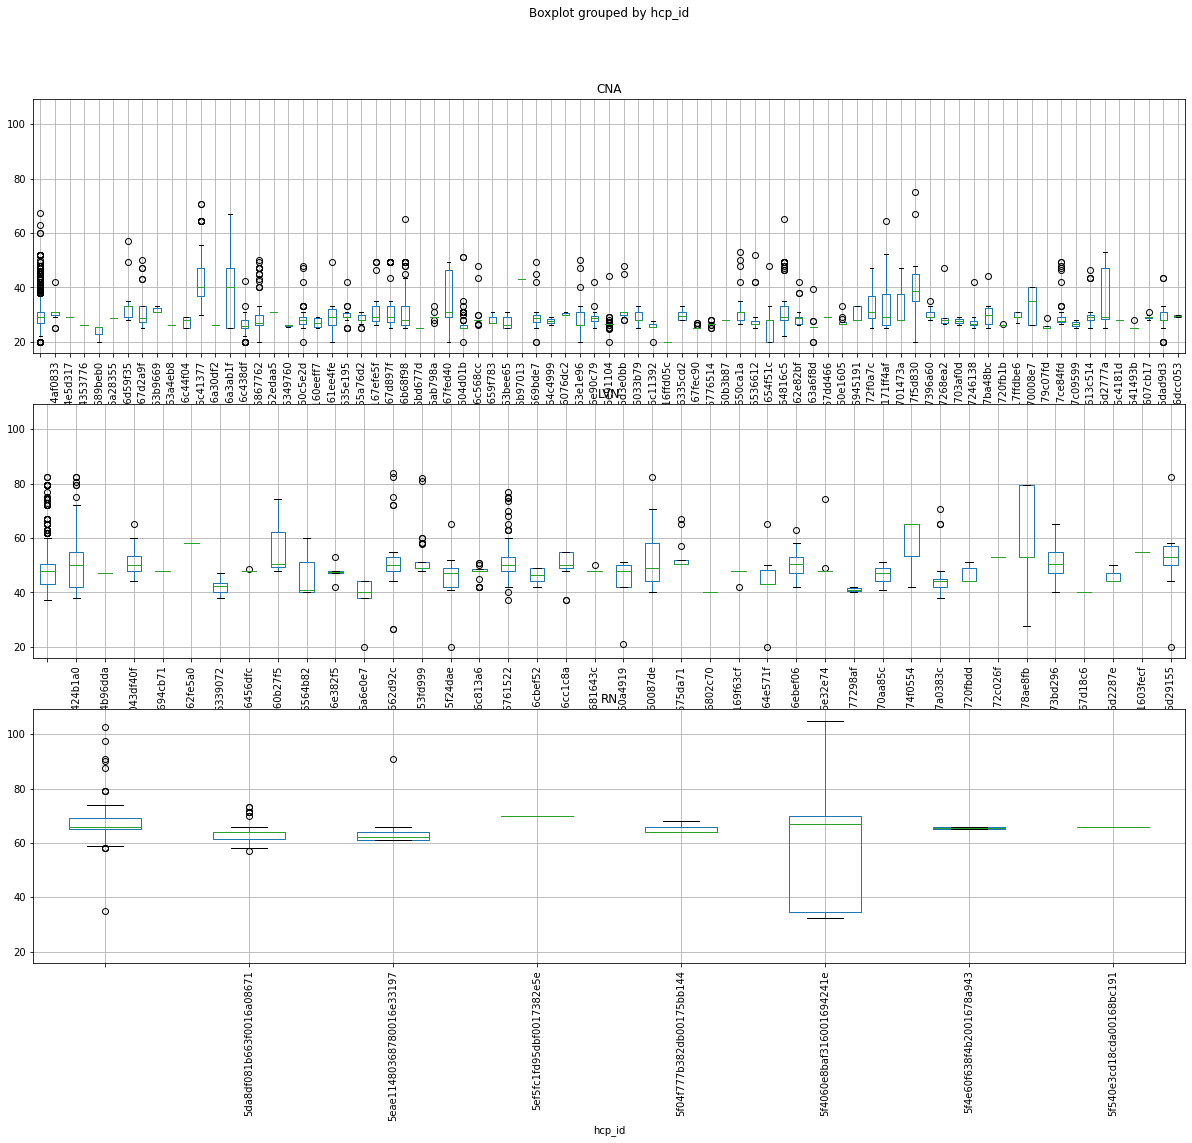

In [6]:
print('FIG 1: Distributions of `charge_rate_hourly` by `hcp_id`')
tsd_bp = tr_shift_data.groupby('agent_type').boxplot(column=['charge_rate_hourly'], by='hcp_id', rot=90,figsize=(20, 16), return_type=None, layout=(3,1))

FIG 1a: Distributions of `charge_rate_hourly` by `agent_type`


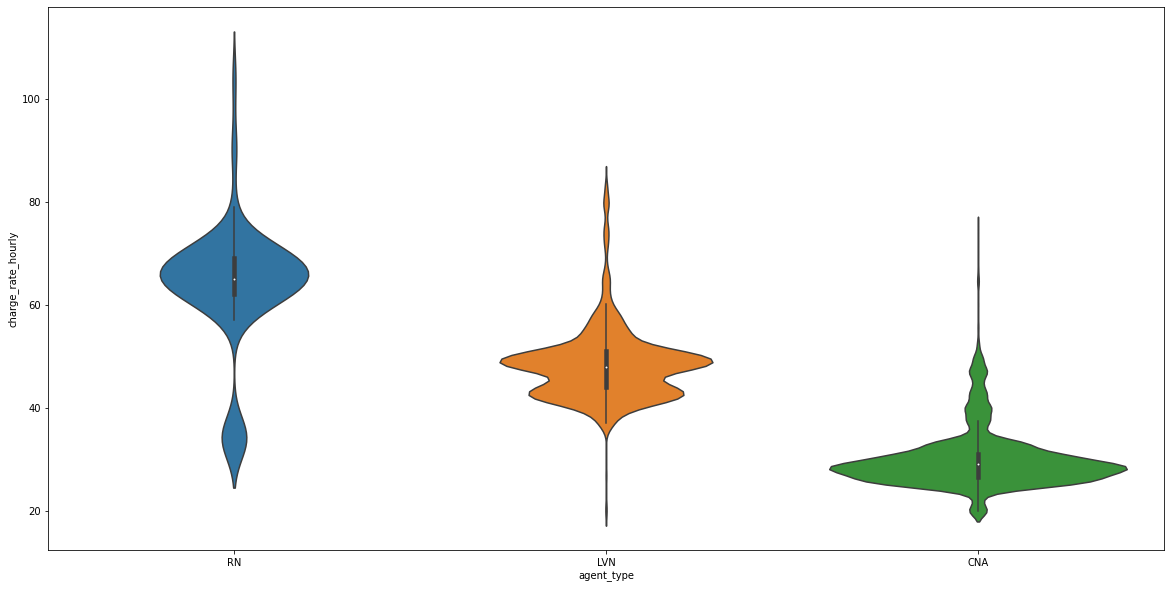

In [7]:
print('FIG 1a: Distributions of `charge_rate_hourly` by `agent_type`')
fig, ax = plt.subplots(figsize =(20, 10))
sns.violinplot(ax = ax, x = tr_shift_data["agent_type"], 
                  y = tr_shift_data["charge_rate_hourly"])
plt.show()

### 4B. What correlates with the variance in charge rates?
([back to questions](#Questions-for-exploratory-data-analysis:))
([back to top](#Table-of-Contents))  


While I was doing a little exploration into the variance above, I looked at a few individual HCPs to see if I could get a sense of what affected their individual `charge_rate_hourly` to help narrow the data exploration surface area. I noticed that a good amount of the variance at the HCP level looked like it correlated with the facility. I also played with calculating the premium against both the mode and the mean, but the mode makes more sense because the fixed rate would occur most frequently and outliers can have a significant affect on the mean. I left in columns for both the mode by hcp and by hcp/hcf combination -- normalizing at the individual HCP level and individual HCP working for a particular HCF level:

- `charge_rate_mode_by_hcp`: the mode of the `charge_rate_hourly` per `hcp_id`
- `charge_rate_premium_by_hcp`: the difference between `charge_rate_hourly` and `charge_rate_mode_by_hcp` 
- `charge_rate_mode_by_hcp_hcf`: the mode of the `charge_rate_hourly` per `hcp_id` and `hcf_id`
- `charge_rate_premium_by_hcp_hcf`: the difference between `charge_rate_hourly` and `charge_rate_mode_by_hcp_hcf`

I used a seaborn pairplot (see references [3] below for more on pairplots) to visualize relationships between select attributes and output tables below with the means of the `charge_rate_premium_by_hcp` and `charge_rate_mode_by_hcp_hcf` to look for patterns.

Notes:
- the `charge_rate_premium_by_hcp` and `charge_rate_premium_by_hcp_hcf` correlate 
    - facility does not explain all of the differences
    - some unknown properties of the facilities may be affecting HCP willingness to adjust their base hourly rate
    - the patterns below hold at both hcp and hcp/hcf levels
- `Shift Start DoW` with higher premiums are _Monday_, _Sunday_, and _Saturday_
- shift length:
    - _noc_ and _pm_ times have slightly higher premiums for CNAs
    - _custom_ times have slightly higher premiums for LVNs
    - but the distributions are wide
- lead time seems to have a big effect with less lead time translating to a higher premium
- date matters with much higher premiums around holidays (Independence Day and Labor Day in this set)
- RN has only 7 verified shifts, data is noisy

Total number of HCP: 117

Seaborn pairplot to compare correlation of columns:
Legend for columns that were converted to categories:


,Shift Start DoW,Shift Start DoW (code)
17,Sunday,0
7250,Monday,1
6987,Tuesday,2
743,Wednesday,3
919,Thursday,4
7706,Friday,5
2903,Saturday,6


,Shift Time,Shift Time (code)
5828,am,0
5333,pm,1
6026,noc,2
87,custom,3


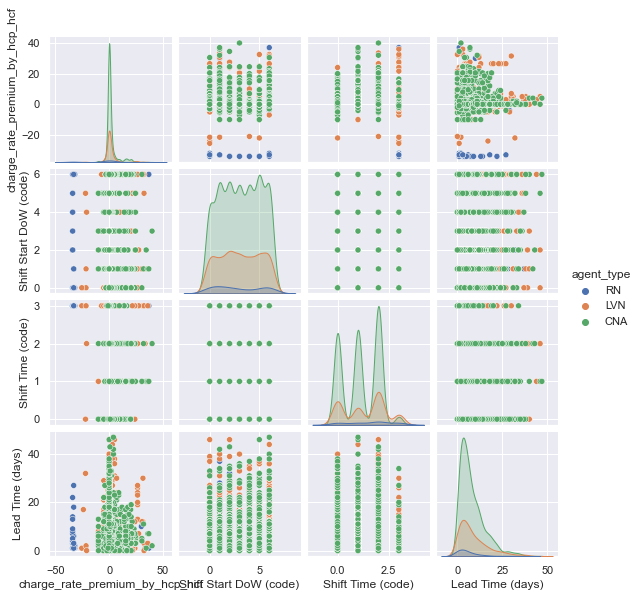

charge_rate_premium_by_hcp mean of modes:


,Shift Start DoW,charge_rate_premium_by_hcp_mean,charge_rate_premium_by_hcp_hcf_mean,count
2,Saturday,4.24,3.51,430
1,Monday,2.58,2.12,388
3,Sunday,2.30,1.81,364
5,Tuesday,1.27,0.72,413
6,Wednesday,0.90,0.41,386
0,Friday,0.87,0.26,414
4,Thursday,0.62,0.18,371


,Shift Time,charge_rate_premium_by_hcp_mean,charge_rate_premium_by_hcp_hcf_mean,count
3,pm,1.92,1.75,755
2,noc,2.67,1.73,1055
0,am,0.93,0.62,793
1,custom,0.80,-0.15,163


,Shift Start (Month),charge_rate_premium_by_hcp_mean,charge_rate_premium_by_hcp_hcf_mean,count
98,2020-09-07,19.75,18.12,31
33,2020-07-04,15.88,15.14,27
75,2020-08-15,8.51,6.79,18
89,2020-08-29,7.75,5.53,18
110,2020-09-19,5.55,5.42,25
...,...,...,...,...
116,2020-09-25,-0.77,-1.33,23
119,2020-09-28,-1.26,-1.41,27
136,2020-10-15,-1.80,-1.80,15
121,2020-09-30,-2.23,-2.20,20


,agent_type,charge_rate_premium_by_hcp_mean,charge_rate_premium_by_hcp_hcf_mean,count
0,CNA,2.32,1.66,1920
1,LVN,1.74,1.41,728
2,RN,-4.98,-5.02,118


,Lead Time (days),charge_rate_premium_by_hcp_mean,charge_rate_premium_by_hcp_hcf_mean,count
0,0-2,2.15,1.20,734
1,3-5,2.78,1.86,621
2,6-11,2.13,1.29,688
3,12-47,0.21,0.77,596


In [8]:
# FIG 2

# limit to verified shifts and print total
tsd_verified_shifts = tr_shift_data.query('`Shift Status` == "verified"')
print('Total number of HCP: {}\n'.format(tsd_verified_shifts['hcp_id'].nunique()))

# print header and legends
print('Seaborn pairplot to compare correlation of columns:')
print('Legend for columns that were converted to categories:')
display(tsd_verified_shifts[['Shift Start DoW', 'Shift Start DoW (code)']].sort_values('Shift Start DoW (code)').drop_duplicates())
display(tsd_verified_shifts[['Shift Time', 'Shift Time (code)']].sort_values('Shift Time (code)').drop_duplicates())

# create Seaborn pairplot for select columns (see references [3] below for more on pairplots)
sns.set()
to_pairplot = [
    'charge_rate_premium_by_hcp_hcf',
    'Shift Start DoW (code)', 
    'Shift Time (code)',
    'Shift Start (Month)',
    'Lead Time (days)',
    'agent_type'
]
sns.pairplot(tsd_verified_shifts[to_pairplot], height = 2, hue='agent_type')
plt.show()

# generate and print tables for select columns
print('charge_rate_premium_by_hcp mean of modes:')
of_interest = [
    'Shift Start DoW', 
    'Shift Time',
    'Shift Start (Month)',
    'agent_type'
]
for i in of_interest:
    display(tsd_verified_shifts.groupby(
        [i], as_index=False).agg(
        charge_rate_premium_by_hcp_mean=pd.NamedAgg(column='charge_rate_premium_by_hcp', aggfunc='mean'),
        charge_rate_premium_by_hcp_hcf_mean=pd.NamedAgg(column='charge_rate_premium_by_hcp_hcf', aggfunc='mean'),
        count=pd.NamedAgg(column='charge_rate_premium_by_hcp', aggfunc='count')
    ).sort_values('charge_rate_premium_by_hcp_hcf_mean', ascending=False))

# group `Lead Time (days)` into quartiles
bins=[0,3,6,12,47]
tsd_verified_shifts_lead_time_bins = tsd_verified_shifts.groupby(pd.cut(tsd_verified_shifts['Lead Time (days)'], bins), as_index=False)
tsd_verified_shifts_lead_time_bins_agg = tsd_verified_shifts_lead_time_bins.agg(
    charge_rate_premium_by_hcp_mean=pd.NamedAgg(column='charge_rate_premium_by_hcp', aggfunc='mean'),
    charge_rate_premium_by_hcp_hcf_mean=pd.NamedAgg(column='charge_rate_premium_by_hcp_hcf', aggfunc='mean'),
    count=pd.NamedAgg(column='charge_rate_premium_by_hcp', aggfunc='count')
)
tsd_verified_shifts_lead_time_bins_agg.insert(
    loc = 0,
    column = 'Lead Time (days)',
    value = [
        '0-2',
        '3-5',
        '6-11',
        '12-47'
    ]
)
display(tsd_verified_shifts_lead_time_bins_agg)

### 4C. What correlates with `Shift Status`?
([back to questions](#Questions-for-exploratory-data-analysis:))
([back to top](#Table-of-Contents))  

In order to maximize revenue, we need to maximize number of shifts posted and number of _verified_ `Shift Status`es while minimizing the others as much as possible. 

This answer is broken into sections below. TL;DR: lead time and day of the week seem to correlate with higher premiums charged, so we may be able to offer HCFs the ability to incentivize HCPs. The total volume of shifts posted and worked is dominated by three HCFs and has an exponentially shaped distribution.

##### Seasonality by date shift posted

First, we need to get an idea of the distributions of the various `Shift Status`es over time to look for seasonality. We can look at the distributions as area charts, starting with the date the shift was posted as both nominal (FIG 3a) and relative (FIG 3a1) values. There are no useful patterns. There are spikes in postings, but there could be technical reasons for those as they look extreme. 

<AxesSubplot:title={'center':'FIG 3a1 Shift Status by date shift posted (% of total)'}, xlabel='Created At (Month)', ylabel='% Shifts'>

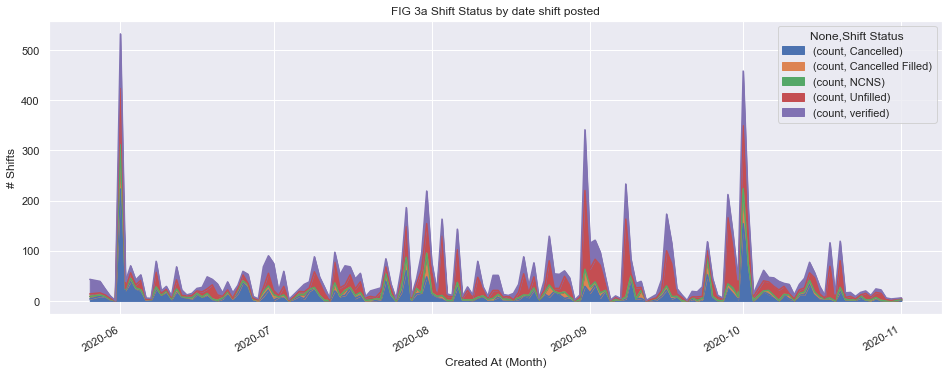

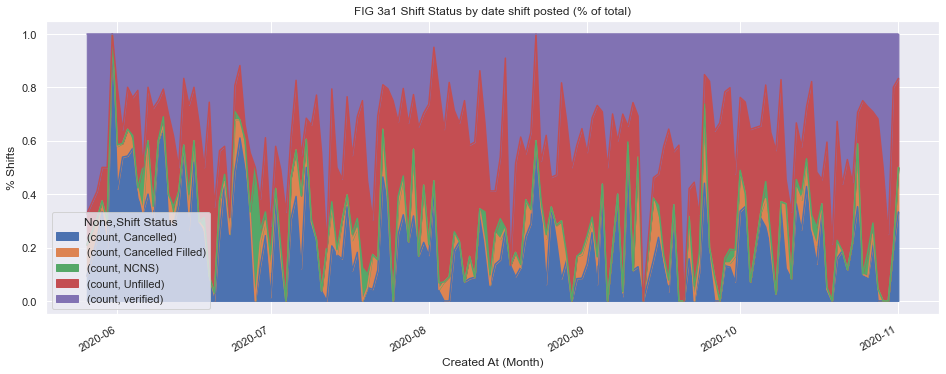

In [9]:
# FIG 3a Shift Status by date posted
shift_status_by_day_posted = tr_shift_data[['Created At (Month)', 'Shift Status']].value_counts().rename('count').to_frame()
shift_status_by_day_posted_pt = shift_status_by_day_posted.pivot_table(index=['Created At (Month)'], columns=['Shift Status'], values=['count'], aggfunc=np.sum).fillna(0.0).apply(np.int64)
shift_status_by_day_posted_pt.plot.area(figsize=(16,6), ylabel='# Shifts', title='FIG 3a Shift Status by date shift posted')

# FIG 3a1 Shift Status by date posted (% of total)
shift_status_by_day_posted_pt = shift_status_by_day_posted_pt.divide(shift_status_by_day_posted_pt.sum(axis=1), axis=0)
shift_status_by_day_posted_pt.plot.area(figsize=(16,6), ylabel='% Shifts', title='FIG 3a1 Shift Status by date shift posted (% of total)')

##### Seasonality by date shift starts

To get a visualization of seasonality by when shifts are actually worked, I plotted the shift status as a stacked area chart over the shift date (FIG 3b). There does seem to be a weekly pattern in total volume of shifts. I also plotted it as a relative percent of the total (FIG 3b1). The percentage of _verified_ `Shift Status`es does go up a bit in early July, but that could be related to volume going down, people needing holiday money, shifts paying more, etc. There is also a slight increase in the slope of the average and peak cumulative volume, hopefully due to growth.

<AxesSubplot:title={'center':'FIG 3b1 Shift Status by date shift starts (% of total)'}, xlabel='Shift Start (Month)', ylabel='% Shifts'>

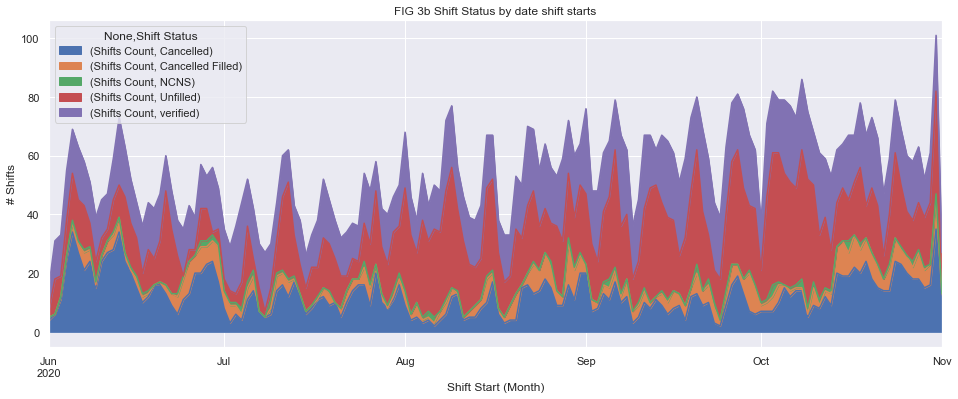

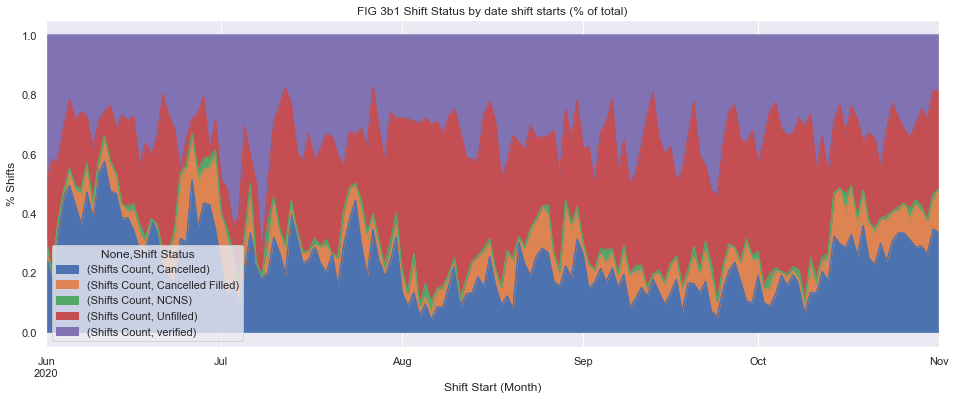

In [10]:
# FIG 3b Shift Status by date shift starts
shift_status_by_day = tr_shift_data[['Shift Start (Month)', 'Shift Status']].value_counts().rename('Shifts Count').to_frame()
shift_status_by_day_pt = shift_status_by_day.pivot_table(index=['Shift Start (Month)'], columns=['Shift Status'], values=['Shifts Count'], aggfunc=np.sum).fillna(0.0).apply(np.int64)
shift_status_by_day_pt.plot.area(figsize=(16, 6), ylabel='# Shifts', title='FIG 3b Shift Status by date shift starts')

# FIG 3b1 Shift Status by date (% of total)
shift_status_by_day_pt = shift_status_by_day_pt.divide(shift_status_by_day_pt.sum(axis=1), axis=0)
shift_status_by_day_pt.plot.area(figsize=(16, 6), ylabel='% Shifts', title='FIG 3b1 Shift Status by date shift starts (% of total)')

##### Seasonality by week

Next, I plotted the shift status over the day of week both cumulatively and relatively to get a closer look at the weekly patterns. There are more shifts posted on the weekends, and the ratio of _verifed_ to _Unfilled_ is lower. HCFs might be willing to pay a premium. We saw that Saturday, Monday, and Sunday already pay the highest premiums to HCPs, there might be an opportunity to pass some of that cost on to HCFs and make the market more efficient.

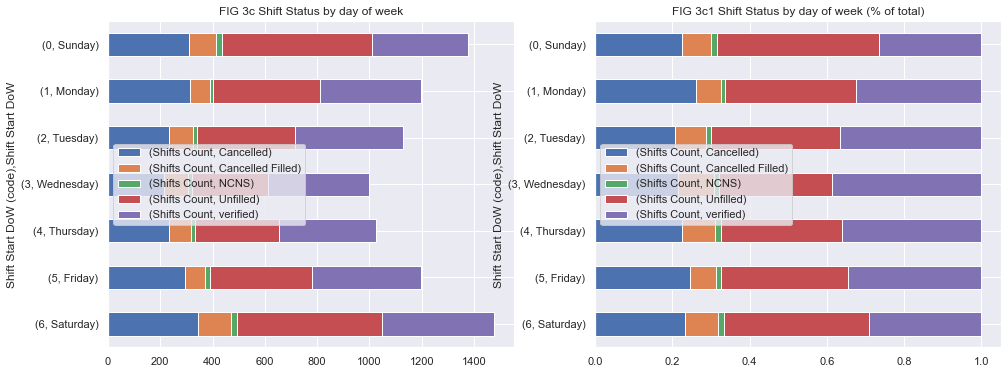

In [11]:
# FIG 3c Shift Status by day of week
fig, axes = plt.subplots(nrows=1, ncols=2)
shift_status_by_dow = tr_shift_data[['Shift Start DoW (code)', 'Shift Start DoW', 'Shift Status']].value_counts().rename('Shifts Count').to_frame()
shift_status_by_dow_pt = shift_status_by_dow.pivot_table(index=['Shift Start DoW (code)', 'Shift Start DoW'], columns=['Shift Status'], values=['Shifts Count'], aggfunc=np.sum).fillna(0.0).apply(np.int64)
shift_status_by_dow_pt.plot(kind='barh', ax = axes[0], figsize=(16, 6), stacked=True, ylabel='# Shifts', title='FIG 3c Shift Status by day of week').invert_yaxis()

# FIG 3c1 Shift Status by day of week (% of total)
shift_status_by_dow_pct_pt = shift_status_by_dow_pt.divide(shift_status_by_dow_pt.sum(axis=1), axis=0)
shift_status_by_dow_pct_pt.plot(kind='barh', ax = axes[1], figsize=(16, 6), stacked=True, ylabel='% Shifts', title='FIG 3c1 Shift Status by day of week (% of total)').invert_yaxis()

axes[0].legend(loc='center left')
axes[1].legend(loc='center left')

plt.show()

##### `Shift Status`es by `Lead Time (days)`
So timing is important, and it makes sense that lead time would have some affect on the number of shifts _verified_ and otherwise. When plotted, there is a definite pattern in the volume of shifts by lead time. Most shifts seem to be posted within a week of them needing to be filled. The number of _verified_ shifts holds steady for about 18 days before the number of _verified_ shifts drops and the number of _Cancelled Filled_ shifts goes up. However, we are also now in the long tail of posts and the volumes here are much lower. There might be an opportunity to allow HCFs to offer incentives based on lead time and push those offers to HCPs.

<AxesSubplot:title={'center':'FIG 3d1 Shift Status by lead time (% of total)'}, xlabel='Lead Time (days)', ylabel='% Shifts'>

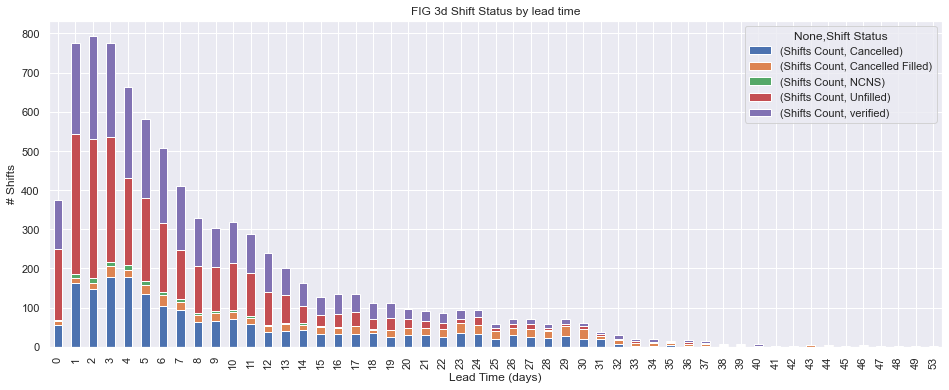

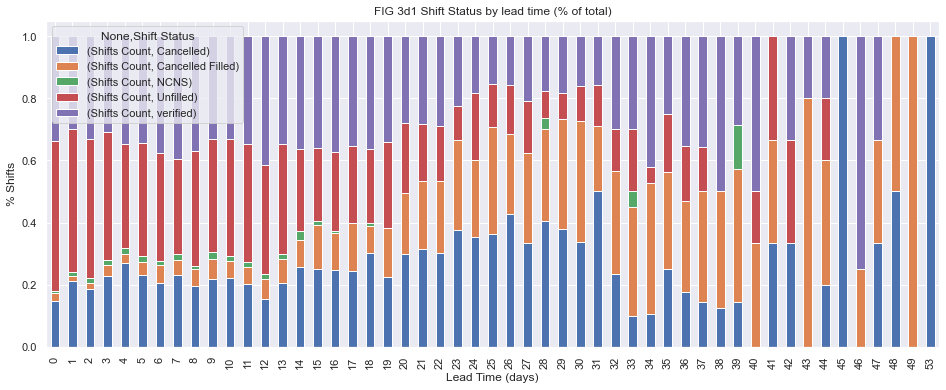

In [12]:
# FIG 3d Shift Status by lead time (days)
shift_status_by_lead_time = tr_shift_data[['Lead Time (days)', 'Shift Status']].value_counts().rename('Shifts Count').to_frame()
shift_status_by_lead_time_pt = shift_status_by_lead_time.pivot_table(index=['Lead Time (days)'], columns=['Shift Status'], values=['Shifts Count'], aggfunc=np.sum).fillna(0.0).apply(np.int64)
shift_status_by_lead_time_pt.plot.bar(figsize=(16, 6), stacked=True, ylabel='# Shifts', title='FIG 3d Shift Status by lead time')

# FIG 3d1 Shift Status by lead time (days) (% of total)
shift_status_by_lead_time_pt = shift_status_by_lead_time_pt.divide(shift_status_by_lead_time_pt.sum(axis=1), axis=0)
shift_status_by_lead_time_pt.plot.bar(figsize=(16, 6), stacked=True, ylabel='% Shifts', title='FIG 3d1 Shift Status by lead time (% of total)')

##### `Shift Status` by `Shift Time`
Again looking into different aspects of timing/scheduling of shifts, it's worth looking into _Shift Time_ differences. It looks like they are pretty close, and the small variations can likely be explained by differences in volume and HCP preferences. 

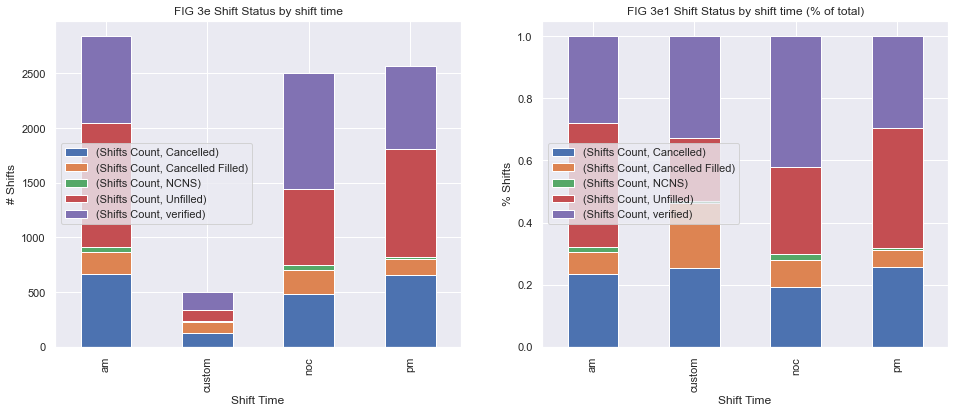

In [13]:
# FIG 3e Shift Status by shift time
fig, axes = plt.subplots(nrows=1, ncols=2)
shift_status_by_shift_time = tr_shift_data[['Shift Time', 'Shift Status']].value_counts().rename('Shifts Count').to_frame()
shift_status_by_shift_time_pt = shift_status_by_shift_time.pivot_table(index=['Shift Time'], columns=['Shift Status'], values=['Shifts Count'], aggfunc=np.sum).fillna(0.0).apply(np.int64)
shift_status_by_shift_time_pt.plot(kind='bar', ax = axes[0], figsize=(16, 6), stacked=True, ylabel='# Shifts', title='FIG 3e Shift Status by shift time')

# FIG 3e1 Shift Status by shift time (% of total)
shift_status_by_shift_time_pct = shift_status_by_shift_time_pt.divide(shift_status_by_shift_time_pt.sum(axis=1), axis=0)
shift_status_by_shift_time_pct.plot(kind='bar', ax = axes[1], figsize=(16, 6), stacked=True, ylabel='% Shifts', title='FIG 3e1 Shift Status by shift time (% of total)')

axes[0].legend(loc='center left')
axes[1].legend(loc='center left')

plt.show()

##### `Shift Status` by HCF
Now that we have looked at how timing affects the expected `Shift Status`, it might be worth exploring if there are any differences between HCFs. This may inform differences by HCF location, operational procedures, execution, and other HCF level variables. We might not be able to dertermine correlation, but it may still be interesting. While there aren't any useful general patterns, we did learn that the volume of shifts is dominated by three big HCFs. Targeting these institutions with offers or working with them to see how we can increase their volume or conversion further.

<AxesSubplot:title={'center':'FIG 3f2 Number of unique HCPs who work at HCFs'}, xlabel='hcf_id', ylabel='# Shifts'>

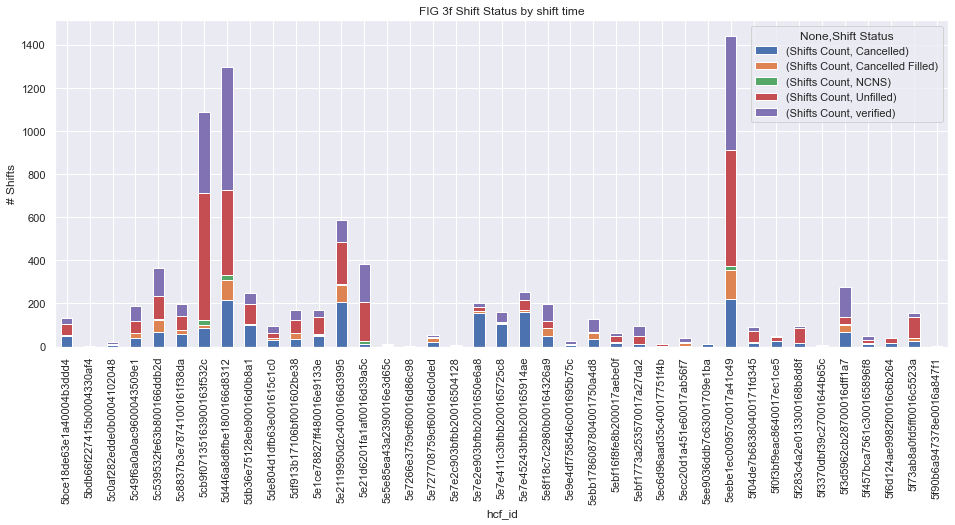

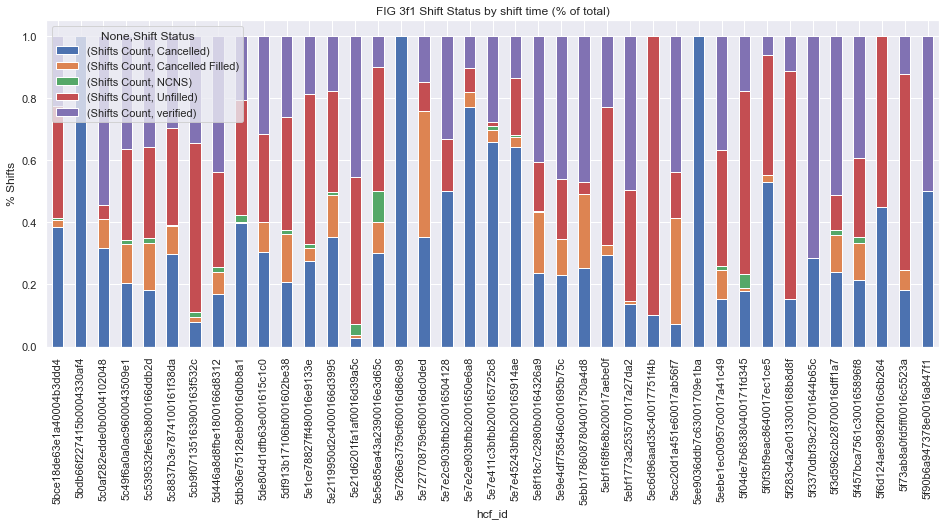

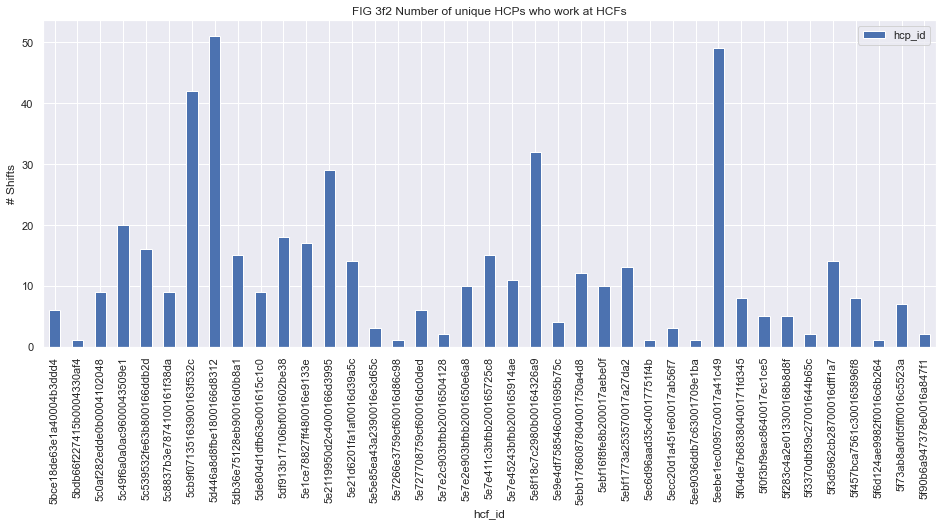

In [14]:
# FIG 3f Shift Status by HCF
shift_status_by_hcf_id = tr_shift_data[['hcf_id', 'Shift Status']].value_counts().rename('Shifts Count').to_frame()
shift_status_by_hcf_id_pt = shift_status_by_hcf_id.pivot_table(index=['hcf_id'], columns=['Shift Status'], values=['Shifts Count'], aggfunc=np.sum).fillna(0.0).apply(np.int64)
shift_status_by_hcf_id_pt.plot.bar(figsize=(16, 6), stacked=True, ylabel='# Shifts', title='FIG 3f Shift Status by shift time')

# FIG 3f1 Shift Status by HCF (% of total)
shift_status_by_hcf_id_pt = shift_status_by_hcf_id_pt.divide(shift_status_by_hcf_id_pt.sum(axis=1), axis=0)
shift_status_by_hcf_id_pt.plot.bar(figsize=(16, 6), stacked=True, ylabel='% Shifts', title='FIG 3f1 Shift Status by shift time (% of total)')

# FIG 3f2 Number of unique HCPs by HCFs
hcp_id_by_hcf_id = tr_shift_data.groupby('hcf_id').nunique()['hcp_id'].to_frame()
hcp_id_by_hcf_id.plot.bar(figsize=(16, 6), stacked=True, ylabel='# Shifts', title='FIG 3f2 Number of unique HCPs who work at HCFs')

### 5. Summary of Findings
([back to top](#Table-of-Contents))  

There is variance in the hourly rate charged and proportion of shifts worked that point to possible market inefficiencies. We should implement features to allow HCFs and HCPs to adjust their rates. HCFs can offer premiums for hard to fill shifts, and HCPs can offer lower rates for guaranteed work. These features should be rolled out taking HCF volume into account.

#### 5A. Learnings
([back to summary](#5.-Summary-of-Findings))
([back to top](#Table-of-Contents))  

Since we were provided with the hourly rate charged by an HCP, we first looked into the assertion that the hourly rates charged by HCPs are fixed. There was enough variation in the hourly rates charged at the individual level and when grouped by certification that it was worth looking into further.

Next, we looked into what correlates with any premiums paid to HCPs. This is the cost per unit of shifts. We added a column with the most frequent rate paid to an HCP by a given HCF to use as a baseline, and one with the difference between the two to use as the premium. 

Premiums were paid for:
- day of the week: Saturday, Monday, and Sunday
- shift time: PM and noctornal shifts
- shift date: shifts around holidays
- lead time: 4-6, 0-3, 7-12 days ahead

In other words weekend night shifts booked within a week paid the most. Holidays as well.

Then we looked into what correlates with shifts being filled or not filled. The overall volume and conversion of shifts. We looked into the seasonality and found that there was a weekly pattern by day of the week. Weekends have the most posts but also the highest percentage unfilled. Lead time also saw a similar pattern, where the quarter of posts within 2 days had the highest percent unfilled, with it dropping for each quartile after (3-5, 6-11, and 12-47 days). The shifts posted were also highly concentrated by HCF.

Between the existing hourly charge rate elasticity and the patterns in unfilled shifts, there may be some inefficiencies in the marketplace. The demand for weekend, night, last minute, and holiday shifts might be higher if they paid more. There may also be an oppotunity to push available shifts to qualified workers instead of having them have to claim shifts. When making changes to the marketplace, the number of shifts posted should be taken into account when rolling out new features and conducting market research.


#### 5B. Limitations
([back to summary](#5.-Summary-of-Findings))
([back to top](#Table-of-Contents))  

This was a very limited dataset. There was quite a bit of missing information that would have been helpful, including but not limited to:

- HCF rates: _there are two sides to any marketplace, data only shows one_
- HCF profiles: _HCF properties that may impact rates_
    - size
    - quality
    - typical cases (volume and type)
    - feedback ratings
    - address (or number of HCPs within travelling distance)
- HCP profiles: _HCP properties that may impact rates_
    - years of experience
    - other qualifications
    - feedback ratings
    - address (or distance to travel to HCFs worked)
    - demographics
    - availability
    - times they wanted a shift but couldn't find one
 
Also, as is typical when doing this kind of analysis, we are limited to looking for correlations in noisy data and using our intuition and qualitative user/customer experience to draw up hypotheses. 

#### 5C. Recommendations
([back to summary](#5.-Summary-of-Findings))
([back to top](#Table-of-Contents))  

Given the findings and limitations above, we should address suspected inefficiencies in the marketplace pricing mechanisms. Since our customers and users are used to a fixed price model, we should introduce features that will allow us to test for rate elasticity for both the supply and demand for shifts. 

The data lines up pretty well with intuition, weekend night shifts that are posted within a week are the hardest to fill. Allow HCFs to offer a premium for those. On the other side, the number of cancelled filled shifts surpassed the number of verified shifts at around 2.5 weeks lead time. So an HCP might be willing to work for a little less to have a guarantee that they will actually work the shift. This way, the rates can move in either direction from the norm.

As we roll out new features, we should take into account the volume of shifts posted by HCF. Three HCFs were responsible for a large percentage of the overall volume of shifts. We should do market research with these firms, and then roll out features to smaller firms first to help work out any bugs and refine the experience. 

- allow HCFs to offer premiums per shift
    - based on:
        - day of week
        - time of day
        - lead time
        - holidays
    - have preset % based on historical trends, also allow any percentage
    - allow for a sliding scale based on lead time
    - push opportunities to HCPs as premiums increase
- allow HCPs to offer (negative) premiums for guaranteed shifts
- account for HCF shift post volume
    - roll out to smaller HCFs first

### References


##### Footnotes
[1] pipenv numpy installation issue, the reason why warnings are suppressed above -- [Link 1](https://github.com/pypa/pipenv/issues/4576), [Link 2](https://github.com/numpy/numpy/issues/17784) 

TODO: check if need to replace with https://github.com/pypa/pipenv/issues/4564#issuecomment-756625303

[2] [mode lambda h/t](https://github.com/pandas-dev/pandas/issues/11562#issuecomment-155119476)  

[3] [More on Seaborn pairplots](https://seaborn.pydata.org/generated/seaborn.pairplot.html)  

##### Documentation
- https://pandas.pydata.org/pandas-docs/stable/index.html
- https://matplotlib.org/stable/contents.html
- https://seaborn.pydata.org/

##### Snippets
- https://stackoverflow.com/questions/16330831/most-efficient-way-to-find-mode-in-numpy-array

##### Learning
- https://seaborn.pydata.org/tutorial/relational.html?highlight=line%20area
- https://www.narrator.ai/blog/when-correlation-is-better-than-causation/
- https://www.geeksforgeeks.org/violin-plot-for-data-analysis/